# Exploring the Magnetic Flux Rope Models functionalities

This Jupyter notebook shows how the this library can be used.

## 1. Import paths and libraries

In [22]:
# This is needed to import the CC and EC Models from this location in this project.
import sys
sys.path.append("..")

In [23]:
from magnetic_flux_rope_models.MFRBaseModel import MFRBaseModel
from magnetic_flux_rope_models.CCModel import CCModel
from magnetic_flux_rope_models.ECModel import ECModel
from magnetic_flux_rope_models.LundquistModel import LundquistModel
from datetime import datetime as dt
import math
import numpy as np
import matplotlib.pyplot as plt

## 2. Instantiate a new magnetic flux rope model

In [3]:
selected_model: str = "ECModel"

if selected_model == "CCModel":
    # Create an instance of the EC model. We will start with the simplest case, the circular-cylindrical (CC) model.
    my_model = CCModel(R=0.05)

elif selected_model == "ECModel":
    my_model = ECModel(delta=0.5, psi=math.radians(30))

elif selected_model == "LundquistModel":
    my_model = LundquistModel()

# The magnetic flux tope model can be printed, which provides a detailed description of its parameters.
print(my_model)

ECModel with parameters:
        - Geometrical:
            - delta = 0.500
            - psi = 30.000 deg
            - R = 0.050 AU
        - Field:
            - n = 1
            - m = 0
            - tau = 1.300
            - C_10 = 1.000
            - B_z_0 = 10.000 nT
            - handedness = 1.


## 3. Explore the geometry of the magnetic flux rope

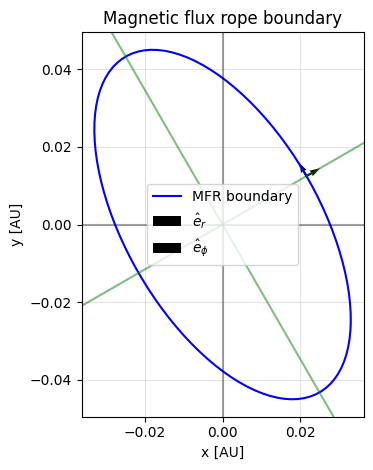

In [4]:
# We can start by plotting the magnetic flux rope boundary.
phi = math.radians(0)
point = my_model.convert_elliptical_to_cartesian_cordinates(r=my_model.R, phi=phi, z=0)
basis = my_model.get_elliptical_unit_basis(r=my_model.R, phi=phi)

my_model.plot_boundary(vector_dict={"$\\hat{e}_r$": (point, basis[:, 0]), "$\\hat{e}_{\\phi}$": (point, basis[:, 1])})

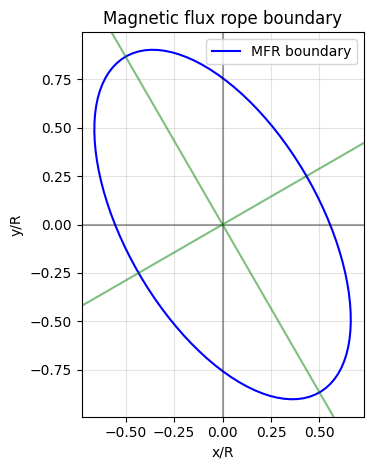

In [5]:
# If we want the plot with the axis normalised by the MFR radius, we can set the following key-word argument to true.
my_model.plot_boundary(normalise_radial_coordinate=True)

In [6]:
area = my_model.get_area()
print(f"MFR area: {area:.5f} AU^2.")

MFR area: 0.00393 AU^2.


# 4. Explore the magnetic and current density fields of the magnetic flux rope

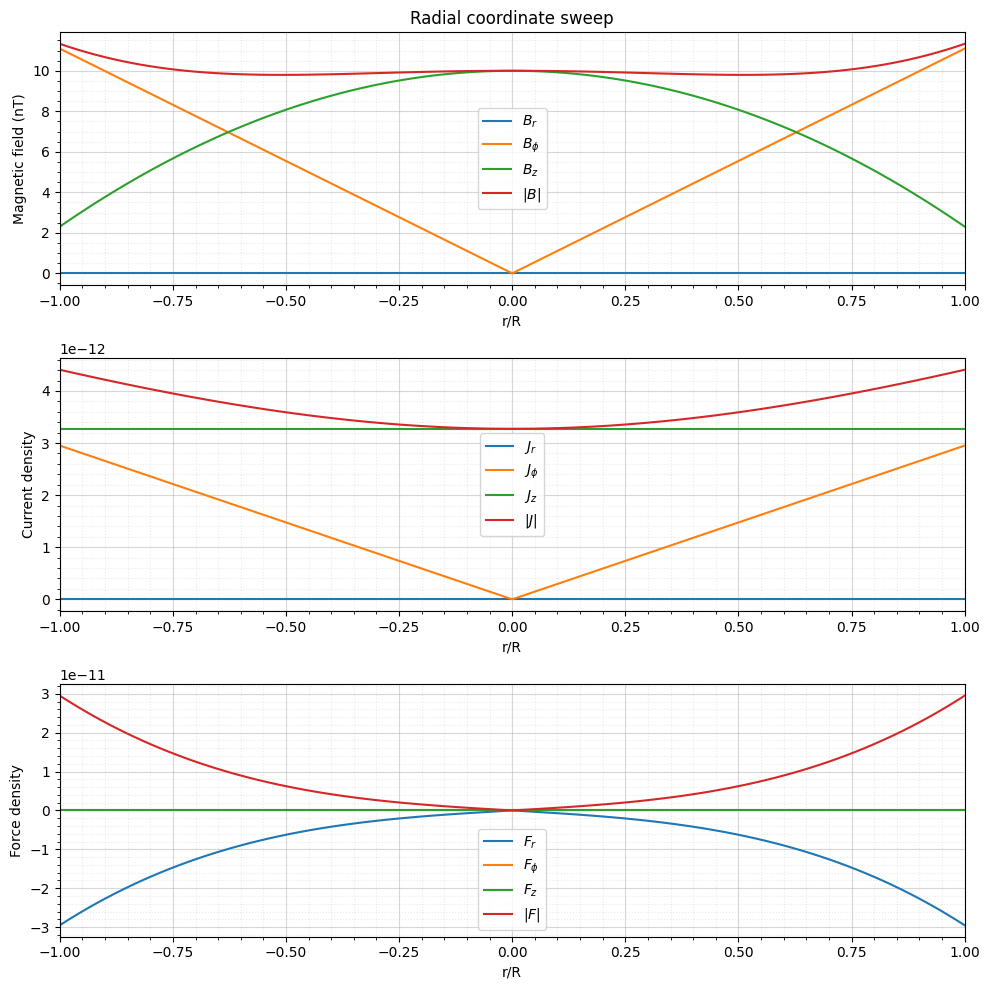

In [7]:
# Next, we can make a radial sweep. The CC model magnetic and current density fields are not dependant on phi, they only depend on the radial coordinate.
r_sweep, B_field, J_field, F_field = my_model.radial_coordinate_sweep(phi=0, two_fold=True, normalise_radial_coordinate=True, plot=True, fig_size=(10, 10))

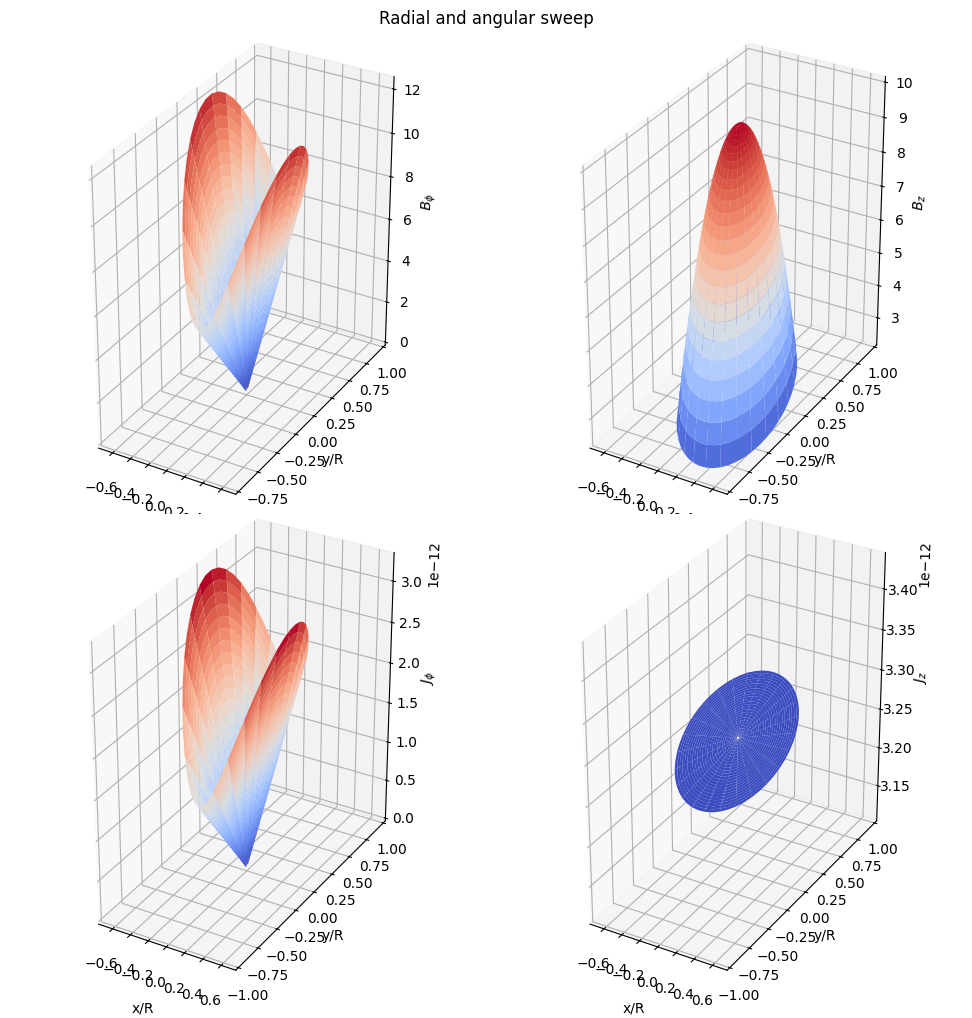

In [8]:
# We can do bot a radial and angluar sweep, showing both magnetic and current density fields. 
x_sweep, y_sweep, B_field, J_field = my_model.radial_and_angular_sweep(plot=True, normalise_radial_coordinate=True, fig_size=(10, 10))

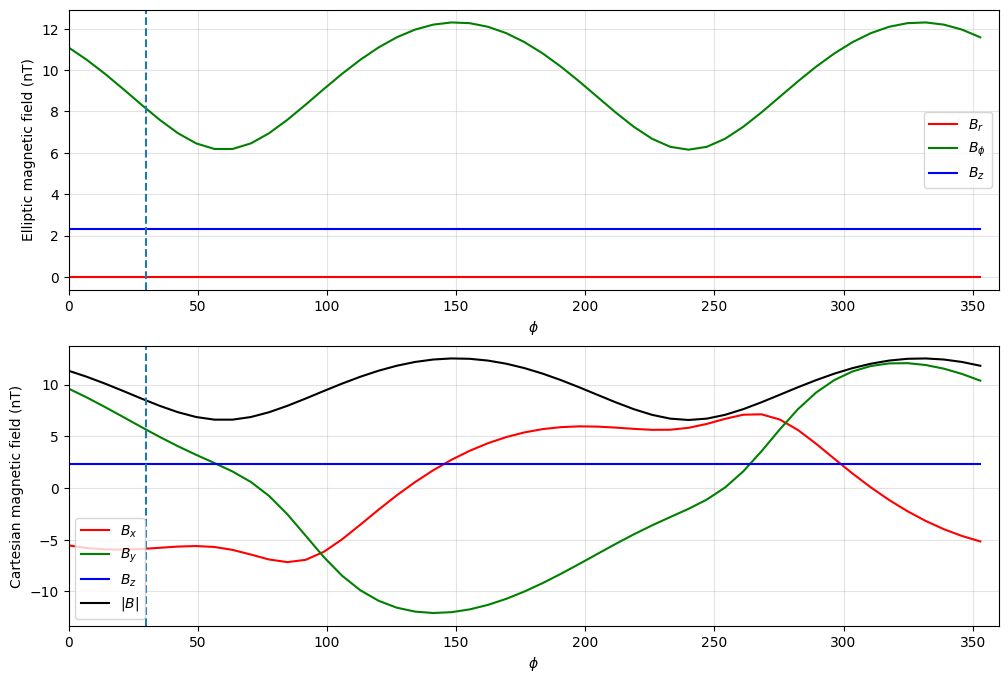

In [9]:
N = 51
phi_range = np.linspace(0, 2*math.pi, N + 1)
phi_range = phi_range[:-1]

B_field_elliptical = np.zeros((N, 3))
B_field = np.zeros((N, 3))

for idx, phi in enumerate(phi_range):
    B_field_elliptical[idx, :] = my_model.get_magnetic_field_elliptical_coordinates(r=my_model.R, phi=phi)
    B_field[idx, :] = my_model.convert_elliptical_to_cartesian_vector(B_field_elliptical[idx, 0], B_field_elliptical[idx, 1], B_field_elliptical[idx, 2], r=my_model.R, phi=phi)

B_magnitude = np.sqrt(np.square(B_field).sum(axis=1))
phi_range_deg = np.rad2deg(phi_range)

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(phi_range_deg, B_field_elliptical[:, 0], label="$B_r$", c="r")
ax[0].plot(phi_range_deg, B_field_elliptical[:, 1], label="$B_\\phi$", c="g")
ax[0].plot(phi_range_deg, B_field_elliptical[:, 2], label="$B_z$", c="b")
ax[0].axvline(x=math.degrees(my_model.psi), linestyle="--")
ax[0].legend()
ax[0].grid(alpha=0.35)
ax[0].set_xlabel("$\\phi$ ")
ax[0].set_ylabel("Elliptic magnetic field (nT)")
ax[0].set_xlim(0, 360)

ax[1].plot(phi_range_deg, B_field[:, 0], label="$B_x$", c="r")
ax[1].plot(phi_range_deg, B_field[:, 1], label="$B_y$", c="g")
ax[1].plot(phi_range_deg, B_field[:, 2], label="$B_z$", c="b")
ax[1].plot(phi_range_deg, B_magnitude, label="$|B|$", c="k")
ax[1].axvline(x=math.degrees(my_model.psi), linestyle="--")
ax[1].legend()
ax[1].grid(alpha=0.35)
ax[1].set_xlabel("$\\phi$ ")
ax[1].set_ylabel("Cartesian magnetic field (nT)")
ax[1].set_xlim(0, 360)

plt.show()

## 5. Simulate a spacecraft crossing through the magnetic flux rope

This library contains a function called `simulate_crossing`, which can be used to simulate the magnitudes that a spacecraft would measure when crossing a magnetic flux rope. This functionality is the link between the mathematical MFR models and the real data measured by spacecraft in the heliosphere.

We can specify crossing parameters like the spacecraft velocity $v_{sc}$ (in km/s) and the impact parameter $y_0$. Additionally, we can also specify an initial time and/or date time. The result of the simulation provides a `pandas` data frame with the simulated measurements. The number of observations can be defined by the used with the `num`

In [10]:
# We can also simulate a crossing of a spacecraft through the magnetic flux rope model.
# We use the "simulate_crossing" method, which returns a pandas data frame.
v_sc = 450.0
y_0 = 0.3
theta=math.radians(15)
df = my_model.simulate_crossing(v_sc=v_sc, y_0=y_0, theta=theta, initial_datetime=dt(year=2024, month=12, day=10))

df.head()

,time,datetime,x,y,z,B_x,B_y,B_z,B,J_x,J_y,J_z,J,F_x,F_y,F_z,F
0,0.000000,2024-12-10 00:00:00.000000000,-0.032149,0.015,-0.008614,2.202026,5.351781,-11.056880,12.479786,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0
1,360.051543,2024-12-10 00:06:00.051542836,-0.031103,0.015,-0.008334,2.019684,5.760629,-10.510717,12.154799,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0
2,720.103086,2024-12-10 00:12:00.103085672,-0.030057,0.015,-0.008054,1.836106,6.148274,-9.969992,11.856361,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0
3,1080.154629,2024-12-10 00:18:00.154628508,-0.029011,0.015,-0.007773,1.651126,6.514698,-9.434642,11.583607,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0
4,1440.206171,2024-12-10 00:24:00.206171344,-0.027965,0.015,-0.007493,1.464549,6.859879,-8.904584,11.335540,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0


In [11]:
sampling_period = df["time"][1] - df["time"][0]
sampling_frequency = 1 / sampling_period

print(f"Sampling period = {sampling_period:.2f} s (frequency = {sampling_frequency*1000:.2f} mHz).")

Sampling period = 360.05 s (frequency = 2.78 mHz).


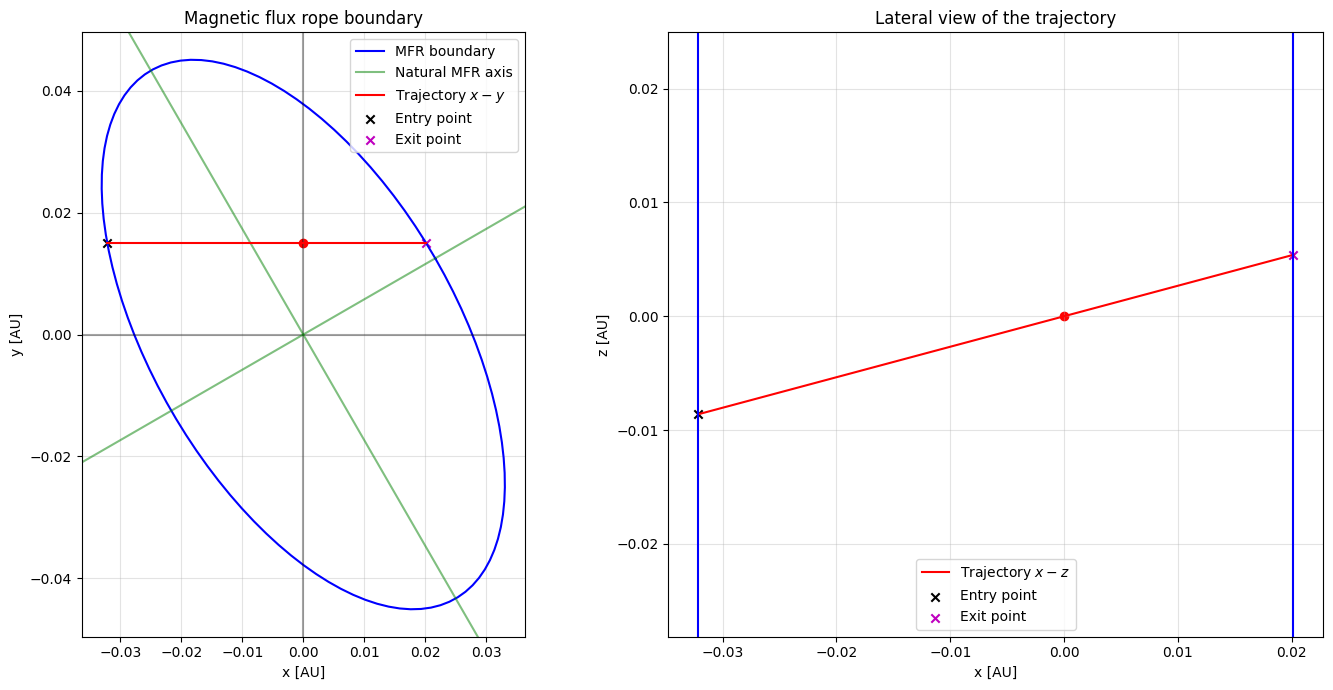

In [12]:
my_model.plot_crossing_trajectory(df)

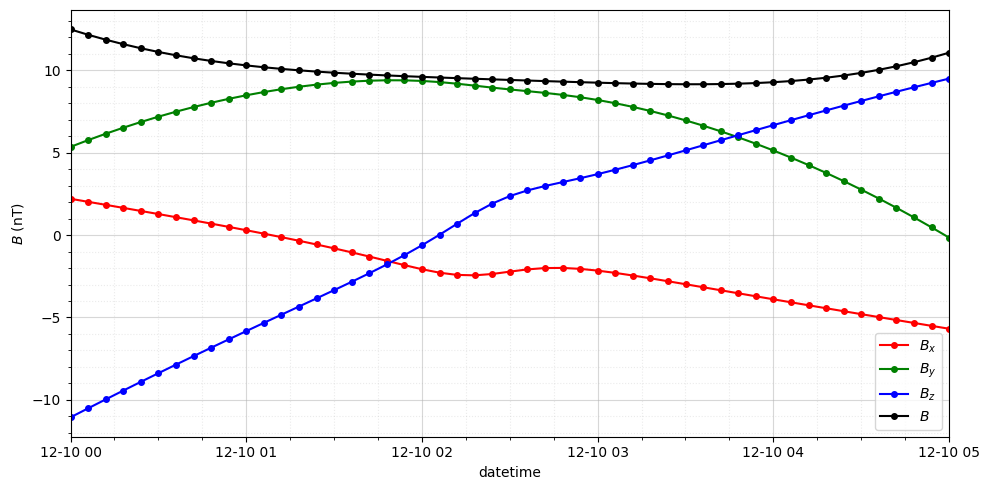

In [13]:
# We can easily plot the magnetic field v.s. time using the "plot_vs_time" method.
my_model.plot_vs_time(df, ["B_x", "B_y", "B_z", "B"], colour=["r", "g", "b", "k"], time_units="h", datetime_axis=True, fig_size=(10, 5))

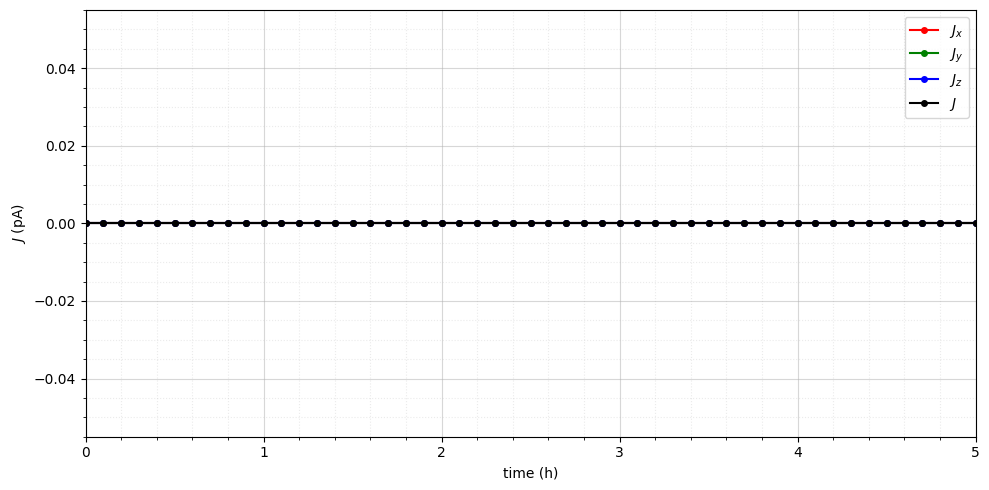

In [14]:
# And we can do the same for the current density.
my_model.plot_vs_time(df, ["J_x", "J_y", "J_z", "J"], colour=["r", "g", "b", "k"], time_units="h", fig_size=(10, 5))

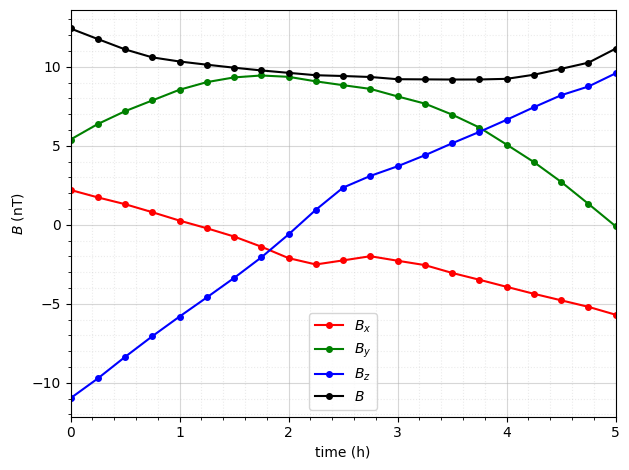

In [15]:
# We can artificially add pseudo-random repeatable noise to the measurements to emulate measurement noise from the spacecraft sensing devices.
df_with_noise = my_model.simulate_crossing(time_stencil=21, theta=math.radians(15), v_sc=v_sc, y_0=y_0, noise_type="gaussian", epsilon=0.05)
my_model.plot_vs_time(df_with_noise, ["B_x", "B_y", "B_z", "B"], colour=["r", "g", "b", "k"], time_units="h")

# 6. Fit a model to the observations

One can fit a MFR model to a set of observations, regardless of if they come from synthetic data, or real measurements. There are two sets of parameters that can be used for the fitting:

- **Model-specific parameters**: for the EC Model, one can specify any of its parameters. If a model parameter is not specified, its default value is used.
- **Crossing parameters**: $v_{sc}$ and $y_0$.

Each of this parameter can be fixed to a value, or optimised. When a parameter is set to "optimised" mode, one can specify their bounds and initial value.

In [16]:
# Start defining the model and crossing parameters.
model_params = {
    "delta": {"mode": "optimised", "bounds": [0.25, 1]},
    "psi": {"mode": "optimised", "bounds": [0, math.radians(179)]},
    "tau": {"mode": "optimised", "bounds": [0.1, 2.5]},
    "B_z_0": {"mode": "optimised", "bounds": [0.5, 25.0]},
    "C_nm": {"mode": "optimised", "bounds": [0.1, 3.0]},
    "n": {"mode": "fixed", "value": 1},
    "m": {"mode": "fixed", "value": 0},
    "R": {"mode": "fixed", "value": 0.05}
}

crossing_params = {
    "y_0": {"mode": "optimised", "bounds": [-0.95, 0.95]},
    "v_sc": {"mode": "fixed", "value": 450.0},
    "theta": {"mode": "optimised", "bounds": [math.radians(-89), math.radians(89)]},
}

# Call the "fit" function.
fitted_model, model_parameters_opt, crossing_parameters_opt, df_fitted, info = MFRBaseModel.fit(ECModel, df_with_noise, model_params, crossing_params, residue_method="RMSE", timeit=True)
fitting_metrics = fitted_model.compute_fitting_metrics(df_with_noise, df_fitted)
fitting_metrics

{'RMSE_x': 0.04162732901892401,
 'RMSE_y': 0.046683513660356245,
 'RMSE_z': 0.04291973819701998,
 'RMSE': 0.07585702931058635,
 'R^2_x': 0.9996545983259146,
 'R^2_y': 0.9996989741867268,
 'R^2_z': 0.9999540795799254,
 'R^2': 0.9998901260919755}

In [17]:
# Show the fitting results: model and fitting parameters.
print(fitted_model)
print(crossing_parameters_opt)

ECModel with parameters:
        - Geometrical:
            - delta = 0.500
            - psi = 30.038 deg
            - R = 0.050 AU
        - Field:
            - n = 1
            - m = 0
            - tau = 1.304
            - C_10 = 0.996
            - B_z_0 = 10.007 nT
            - handedness = 1.
{'y_0': np.float64(0.30009867683285923), 'theta': np.float64(0.26345063603394625), 'v_sc': 450.0, 'time_stencil': array([    0.        ,   900.12885709,  1800.25771418,  2700.38657127,
        3600.51542836,  4500.64428545,  5400.77314254,  6300.90199963,
        7201.03085672,  8101.15971381,  9001.2885709 ,  9901.41742799,
       10801.54628508, 11701.67514217, 12601.80399926, 13501.93285635,
       14402.06171344, 15302.19057053, 16202.31942762, 17102.44828471,
       18002.5771418 ])}


Analyse the results.


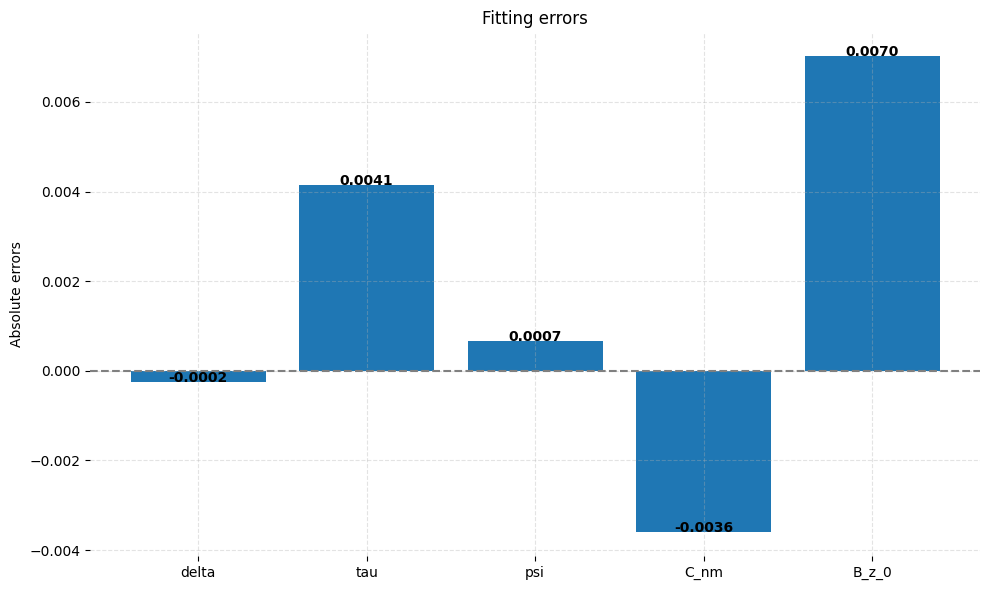

In [18]:
fitting_errors = dict()

for param in ["delta", "tau", "psi", "C_nm", "B_z_0"]:
    if param in my_model.__dict__:
        fitting_errors[param] = model_parameters_opt[param] - my_model.__dict__[param]
    # r"$\delta$": fitted_model.delta - my_model.delta,
    # r"$\tau$": fitted_model.tau - my_model.tau,
    # r"$\psi$": math.degrees(fitted_model.psi - my_model.psi),
    # r"$C_{nm}$": fitted_model.C_nm - my_model.C_nm,
    # "$B_z^0$": fitted_model.B_z_0 - my_model.B_z_0,
    # "$y_0$": crossing_parameters_opt["y_0"] - y_0
#}

fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)
bars = ax.bar(fitting_errors.keys(), fitting_errors.values())
ax.axhline(0, linestyle="--", color="grey")
ax.grid(alpha=0.35, linestyle="--")
ax.set_title("Fitting errors")
ax.set_ylabel("Absolute errors")

# Hide the axes.
for orientation in ["top", "right", "left", "bottom"]:
    ax.spines[orientation].set_visible(False)

for bar in bars:
  bar_height = bar.get_height()
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar_height,
      f"{bar_height:.4f}",
      horizontalalignment="center",
      color="k",
      weight="bold"
  )

plt.show()

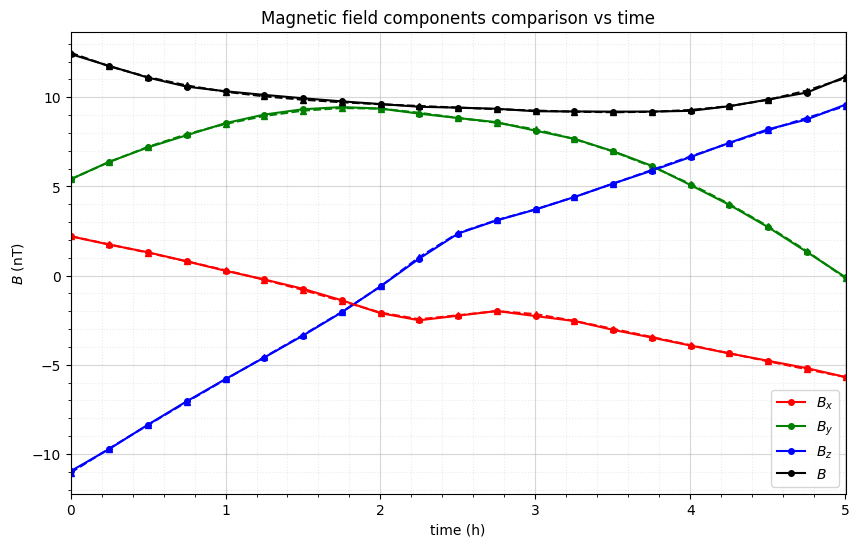

In [19]:
my_model.plot_crossing_magnetic_difference(df_with_noise, df_fitted)


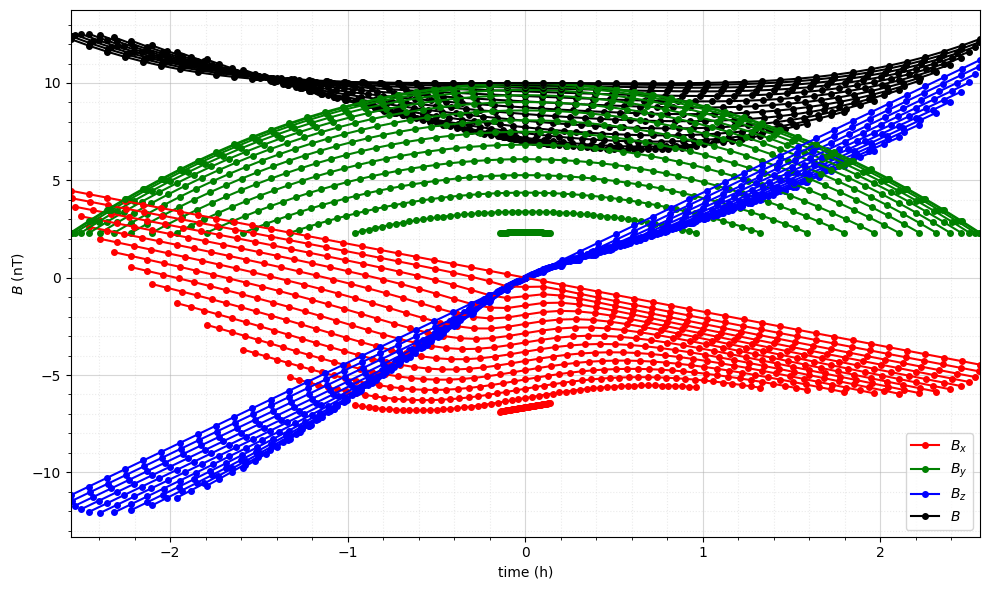

In [20]:
fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)
for y_0 in np.linspace(0.9, 0, 15):
    df = my_model.simulate_crossing(v_sc=450.0, y_0=y_0)
    df["time"] = df["time"] - (df["time"].max() - df["time"].min())/2
    my_model.plot_vs_time(df, ["B_x", "B_y", "B_z", "B"], colour=["r", "g", "b", "k"], time_units="h", ax=ax)
plt.show()

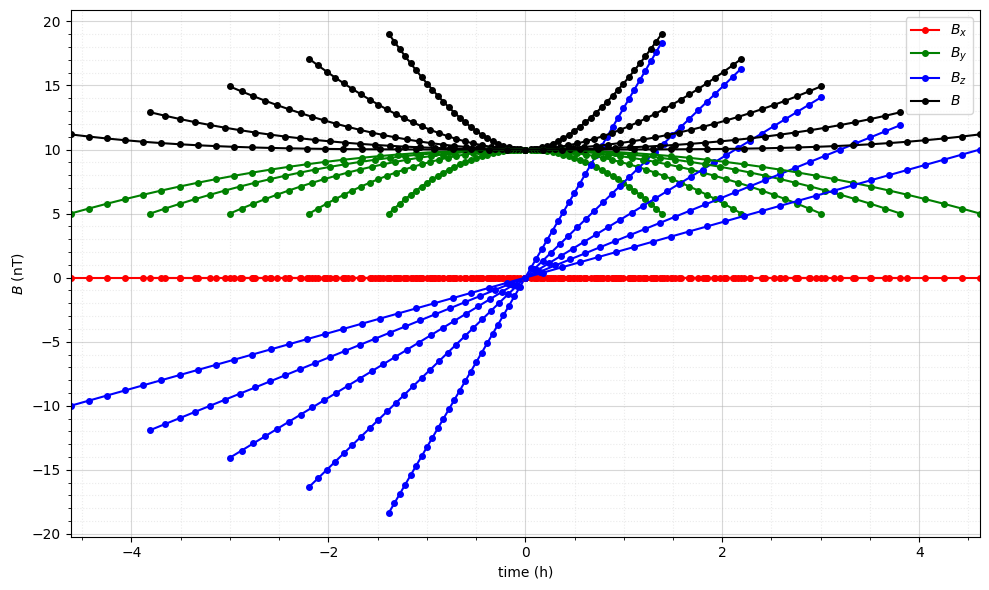

In [21]:
fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)
for delta in np.linspace(0.3, 1, 5):
    model = ECModel(delta=delta, psi=0, tau=2, C_nm=0.5)
    df = model.simulate_crossing(v_sc=450.0, y_0=0)
    df["time"] = df["time"] - (df["time"].max() - df["time"].min())/2
    model.plot_vs_time(df, ["B_x", "B_y", "B_z", "B"], colour=["r", "g", "b", "k"], time_units="h", ax=ax)
plt.show()